In [1]:
import mysql_adactivity_save
import pandas as pd
import facebook_datacollector as datacollector
DATABASE = "dev_facebook_test"

BRANDING_LIST = ['LINK_CLICKS', 'ALL_CLICKS', 'VIDEO_VIEWS', 'REACH', 'IMPRESSIONS']

TIME_WINDOW_CONST = 36
PREDICT_STEP = 6

In [2]:
def make_df_train(df_train):
    df_train = pd.concat([df_train.shift(-5),df_train.shift(-4),df_train.shift(-3),df_train.shift(-2),df_train.shift(-1),df_train], axis=1, sort=False)

    df_train = df_train.dropna().reset_index(drop=True)
    return df_train

In [3]:
def make_predict():
#     %matplotlib inline
    df_camp = mysql_adactivity_save.get_campaign_target()
    df_branding = df_camp[df_camp['charge_type'].isin( BRANDING_LIST )]
    branding_campaign_id_list = df_branding.campaign_id.tolist()
    mydb = mysql_adactivity_save.connectDB(DATABASE)
    mycursor = mydb.cursor()
    print('[campaign_id_list]: ', branding_campaign_id_list)
    for campaign_id in branding_campaign_id_list:
        print('[campaign id]: ', campaign_id)
        insights_sql = "select campaign_id, bid_amount from campaign_insights where campaign_id={} order by request_time desc limit 1".format(campaign_id)
        df_insights = pd.read_sql( insights_sql , con=mydb )
        sql = "select cost_per_target from campaign_insights where campaign_id={} order by request_time desc limit {}".format(campaign_id,TIME_WINDOW_CONST)
        df = pd.read_sql( sql , con=mydb )
        df_train_y = df.head(PREDICT_STEP)
        df_train_y = make_df_train(df_train_y)
        df.drop(df.head(PREDICT_STEP).index, inplace=True)
        if len(df) < TIME_WINDOW_CONST and len(df) >= PREDICT_STEP:
            size = len(df.index)//PREDICT_STEP * PREDICT_STEP
            df_train_x = df.head(size)
            df_train_x = make_df_train(df_train_x)
            result = i_love_predict(df_train_x, df_train_y)
            df_insights['predict_bids'] = result
            mysql_adactivity_save.intoDB("campaign_predict_bids", df_insights)
        else:
            print('[make_predict]: campaign_id {} not enough data to predict.'.format(campaign_id))
    mydb.close()
    mycursor.close()

In [4]:
# %matplotlib inline
def i_love_predict(df_train_x, df_train_y):
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn import linear_model
    from sklearn.metrics import mean_squared_error, r2_score
    regr = linear_model.Ridge(alpha=0.1)
    regr.fit(df_train_x.iloc[0].as_matrix().reshape(-1,1), df_train_y.iloc[0].as_matrix().reshape(-1,1))
    df_y_pred = regr.predict(df_train_y['cost_per_target'].iloc[0].as_matrix().reshape(-1, 1))
    plt.plot([i for i in range(12)],
             df_train_x['cost_per_target'].iloc[0].as_matrix().reshape(1,-1)[0].tolist() + df_y_pred.reshape(1,-1)[0].tolist(),
             color='blue', linewidth=3)

    plt.xticks(())
    plt.yticks()

    plt.show()
    return str(df_y_pred.reshape(1,-1)[0].tolist())

[campaign_id_list]:  [23843358370700576, 23843546765400616, 23843431154770620, 23843584924490768, 23843460479780395]
[campaign id]:  23843358370700576


/home/tim_su/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/tim_su/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
/home/tim_su/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


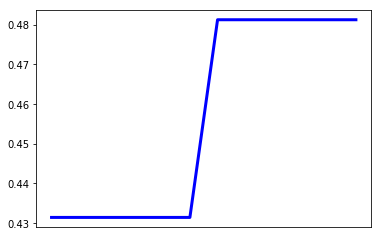

[campaign id]:  23843546765400616


/home/tim_su/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/tim_su/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
/home/tim_su/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


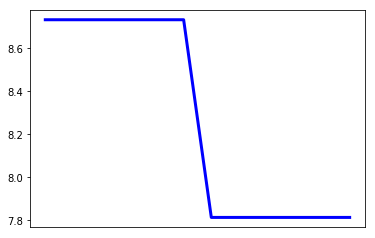

[campaign id]:  23843431154770620
[make_predict]: campaign_id 23843431154770620 not enough data to predict.
[campaign id]:  23843584924490768
[make_predict]: campaign_id 23843584924490768 not enough data to predict.
[campaign id]:  23843460479780395
[make_predict]: campaign_id 23843460479780395 not enough data to predict.


In [5]:
# %matplotlib inline
if __name__ == '__main__':
    make_predict()

In [7]:
#!jupyter nbconvert --to script i_love_predictive_bids.ipynb

[NbConvertApp] Converting notebook i_love_predictive_bids.ipynb to script
[NbConvertApp] Writing 3179 bytes to i_love_predictive_bids.py
